You can use this template for problems 1, 2 and 3

In [356]:
import numpy as np
import time
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
# Students will submit their files with their team-name.py
# Student have to use the Team as their parent class

Recent Version of the Code

In [357]:
class ROLLNUMBER_Q3:
  def __init__(self):
    self.num_arms = 6
    self.runs = np.zeros(self.num_arms)
    self.occur = np.zeros(self.num_arms)
    self.wickets = np.zeros(self.num_arms)
    self.a = np.ones(self.num_arms)
    self.b = np.ones(self.num_arms)
    self.a_w = np.ones(self.num_arms)
    self.b_w = np.ones(self.num_arms)
    self.hmap = np.array([0, 1, 2, 3, 4, 6])
    self.round = 0 
    self.prev_action = 0

  def get_action(self,wicket,runs_scored):
    X = wicket
    R = runs_scored
    
    if self.round > 0:
        if X==1:
            self.a_w[self.prev_action] += 1
        else:
            if (R==self.prev_action) or (R==self.prev_action+1):
                self.a[self.prev_action] += 1
            else:
                self.b[self.prev_action] += 1
            self.b_w[self.prev_action] += 1
        
    if self.round < 6:
        action = self.round
        
    else:
        em_out = np.random.beta(self.a_w, self.b_w)
        em_run = np.random.beta(self.a, self.b)
        thompson = (1-em_out)*em_run*self.hmap/(em_out)
        action = np.argmax(thompson)
    
    self.prev_action = action
    self.round += 1
    
    return action
        


In [397]:
class ROLL_NUMBER_Q3_KL:
  def __init__(self):
    self.num_arms = 6
    self.wickets = np.zeros(self.num_arms)
    self.occur = np.zeros(self.num_arms)
    self.runs = np.zeros(self.num_arms)
    self.prev_action = 0
    self.round = 0
    self._hmap = np.array([1,1,2,3,4,6])
    self.hmap = np.array([0,1,2,3,4,6])
    self.epsilon = 1e-5
    
  @staticmethod
  def kl_div(p, q):
    if p==0 and q==0:
        return 0
    if p!=0 and q==0:
        return pow(10, 10)
    if p==1 and q==1:
        return 0
    if p!=1 and q==1:
        return pow(10, 10)
    if p==0:
        return np.log(1/(1-q))
    if p==1:
        return np.log(1/q)
    
    return p*np.log(p/q) + (1-p)*np.log((1-p)/(1-q))

  def kl_conf(self, t, em, num_pulls, precision=1e-6, max_iter=50):
    n = 0
    upper_bound = 1
    lower_bound = em
    
    while n<max_iter and (upper_bound-lower_bound)>precision:
        q = (upper_bound + lower_bound)/2
        
        if self.kl_div(em, q) < np.log(1+t*np.log(t)**2)/num_pulls:
            upper_bound = q
        else:
            lower_bound = q
            
        n+=1
    
    return (upper_bound+lower_bound)/2

  def get_action(self, wicket, run):
    X = wicket
    R = run
    
    if self.round>0:
        self.runs[self.prev_action] += R
        self.wickets[self.prev_action] += X
        self.occur[self.prev_action] += 1
    
    if self.round < 6:
        action = self.round
        
    else:
        kl_conf_num = np.array([self.kl_conf(self.round, (self.runs[idx]/self._hmap[idx])/self.occur[idx], self.occur[idx]) for idx in range(6)])
        kl_conf_den = np.array([self.kl_conf(self.round, (1-self.wickets[idx]/self.occur[idx]), self.occur[idx]) for idx in range(6)])
        action = np.argmax(kl_conf_num*self.hmap/(1-kl_conf_den+self.epsilon))
                                
        norm = np.sum(self.runs/self._hmap/(self.wickets+self.epsilon))
        kl_conf = np.array([self.kl_conf(self.round, (self.runs[idx]/self._hmap[idx]/(self.wickets[idx]+self.epsilon))/norm, self.occur[idx]) for idx in range(6)])
        action = np.argmax(kl_conf_num*self.hmap)
        
    self.prev_action = action
    self.round += 1
    
    return action
    

In [398]:
class Environment:
  def __init__(self,num_balls,agent):
    self.num_balls = num_balls
    self.agent = agent
    self.__run_time = 0
    self.__total_runs = 0
    self.__total_wickets = 0
    self.__runs_scored = 0
    self.__start_time = 0
    self.__end_time = 0
    self.__regret_w = 0
    self.__regret_s = 0
    self.__wicket = 0
    self.__regret_rho = 0
    self.__p_out = np.array([0.001,0.01,0.02,0.03,0.1,0.3])
    self.__p_run = np.array([1,0.9,0.85,0.8,0.75,0.7])
    self.__action_runs_map = np.array([0,1,2,3,4,6])
    self.__s = (1-self.__p_out)*self.__p_run*self.__action_runs_map
    self.__rho = self.__s/self.__p_out
    self.regret_rho_hist = []


  def __get_action(self):
    self.__start_time      = time. time()
    action          = self.agent.get_action(self.__wicket,self.__runs_scored)
    self.__end_time        = time. time()
    self.__run_time   = self.__run_time + self.__end_time - self.__start_time
    return action


  def __get_outcome(self, action):
    pout = self.__p_out[action]
    prun= self.__p_run[action]
    wicket = np.random.choice(2,1,p=[1-pout,pout])[0]
    runs = 0
    if(wicket==0):
      runs = self.__action_runs_map[action]*np.random.choice(2,1,p=[1-prun,prun])[0]
    return wicket, runs


  def innings(self):
    self.__total_runs = 0
    self.__total_wickets = 0
    self.__runs_scored = 0

    for ball in range(self.num_balls):
      action = self.__get_action()
      self.__wicket, self.__runs_scored   = self.__get_outcome(action)
      self.__total_runs     = self.__total_runs + self.__runs_scored
      self.__total_wickets  = self.__total_wickets + self.__wicket
      self.__regret_w       = self.__regret_w+ (self.__p_out[action]-np.min(self.__p_out))
      self.__regret_s       = self.__regret_s+ (np.max(self.__s) - self.__s[action])
      self.__regret_rho       = self.__regret_rho+ (np.max(self.__rho)-self.__rho[action])
      self.regret_rho_hist += [self.__regret_rho]
    return self.__regret_w,self.__regret_s,self.__regret_rho, self.__total_runs, self.__total_wickets, self.regret_rho_hist, self.__run_time


In [399]:
n = 50
rho_hist = []
for i in range(n):
    n_balls = 1000
    agent = ROLL_NUMBER_Q3_KL()
    environment = Environment(n_balls,agent)
    regret_w,regret_s,reger_rho,total_runs,total_wickets, regret_rho_hist, run_time = environment.innings()
    rho_hist.append(reger_rho)
print(np.mean(reger_rho))

6018.700000000113


In [394]:
n = 50
rho_hist = []
for i in range(n):
    n_balls = 1000
    agent = ROLLNUMBER_Q3()
    environment = Environment(n_balls,agent)
    regret_w,regret_s,reger_rho,total_runs,total_wickets, regret_rho_hist, run_time = environment.innings()
    rho_hist.append(reger_rho)
print(np.mean(reger_rho))

8329.400000000087


In [388]:
print(regret_w,regret_s,reger_rho,total_runs,total_wickets,run_time)

17.81100000000024 1680.5879999999877 4507.8000000000275 1209 25 0.05877351760864258


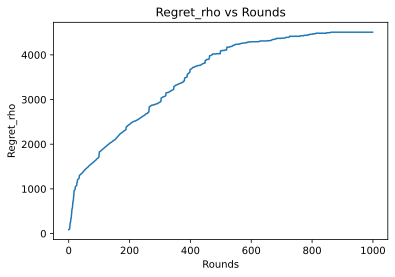

In [389]:
plt.plot(range(n_balls), regret_rho_hist)
plt.xlabel("Rounds")
plt.ylabel("Regret_rho")
plt.title("Regret_rho vs Rounds")
plt.show()